In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [3]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [4]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [5]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [6]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline




Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values

X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


In [7]:
print(X_train_balanced.shape, X_test_balanced.shape)
print(X_train_imbalanced.shape, X_test_imbalanced.shape)

(1750, 11) (430, 11)
(7188, 11) (1797, 11)


In [31]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    842
1.0    558
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [21]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score



def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Random Forest Classifier

Selected Features: [False False  True False  True False  True  True  True  True  True]
Feature Ranking: [4 3 1 2 1 5 1 1 1 1 1]
real_positives = 558.0, total = 1400
Balanced train Accuracy: 0.91
Balanced train Precision: 0.9014869888475836
Balanced train Recall: 0.8691756272401434
Balanced train Specificity: 0.9370546318289786
Balanced train F1 Score: 0.885036496350365


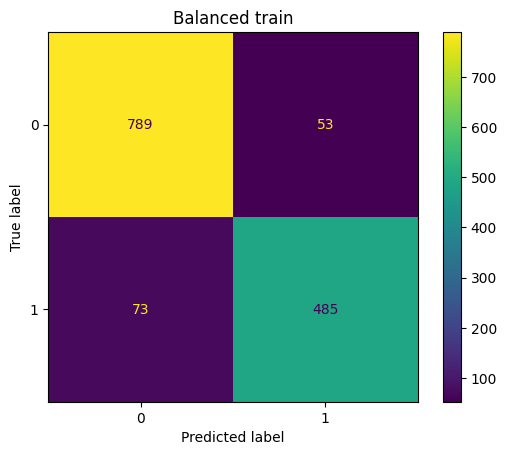

real_positives = 142.0, total = 350
Balanced test Accuracy: 0.7457142857142857
Balanced test Precision: 0.6992481203007519
Balanced test Recall: 0.6549295774647887
Balanced test Specificity: 0.8076923076923077
Balanced test F1 Score: 0.6763636363636364


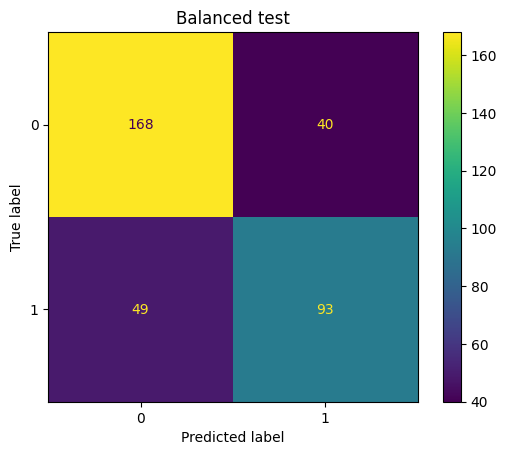

real_positives = 133.0, total = 1438
Imbalanced test Accuracy: 0.8407510431154381
Imbalanced test Precision: 0.35093167701863354
Imbalanced test Recall: 0.849624060150376
Imbalanced test Specificity: 0.8398467432950192
Imbalanced test F1 Score: 0.4967032967032967


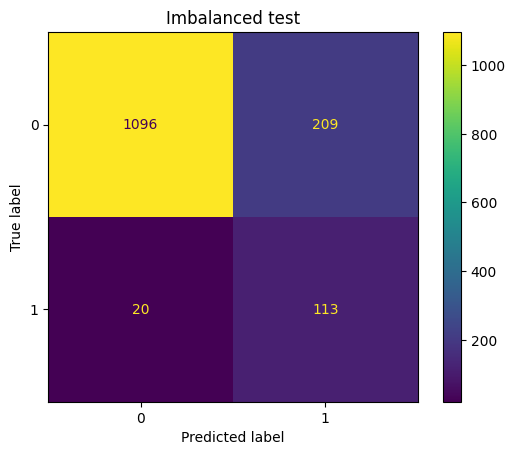

In [34]:
import xgboost as xgb

# Create a Random Forest classifier
base_estimator = (xgb.XGBClassifier(
    random_state = 37,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree= 0.6,
    learning_rate= 0.15,
    max_depth= None,
    min_child_weight= 2,
    n_estimators= 80,
    subsample= 0.5
))

# Create RFECV object with Random Forest as the estimator
base_estimator_rfe = RFECV(estimator=base_estimator, step=1, cv=5, scoring='f1')

# Fit RFECV
base_estimator_rfe.fit(X_train_balanced, y_train_balanced)

# Transform the data
X_train_selected = base_estimator_rfe.transform(X_train_valid_balanced)
X_valid_selected = base_estimator_rfe.transform(X_valid_valid_imbalanced)
X_valid_selected_balanced = base_estimator_rfe.transform(X_valid_valid_balanced)

# Train a new classifier using only selected features
estimator_final = (xgb.XGBClassifier(
    random_state = 37,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree= 0.6,
    learning_rate= 0.15,
    max_depth= None,
    min_child_weight= 2,
    n_estimators= 80,
    subsample= 0.5
))


estimator_final.fit(X_train_selected, y_train_valid_balanced)

# Predict and calculate accuracy
y_pred = estimator_final.predict(X_valid_selected)
y_pred_balanced = estimator_final.predict(X_valid_selected_balanced)
y_pred_train = estimator_final.predict(X_train_selected)

print("Selected Features:", base_estimator_rfe.support_)
print("Feature Ranking:", base_estimator_rfe.ranking_)


eval(y_train_valid_balanced, y_pred_train, 'Balanced train')
eval(y_valid_valid_balanced, y_pred_balanced, 'Balanced test')
eval(y_valid_valid_imbalanced, y_pred, 'Imbalanced test')

In [73]:
display(pd.DataFrame(zip((REDUCED_FEATURE_SET), base_estimator_rfe.support_, base_estimator_rfe.ranking_), columns=['feature', 'include', 'ranking']).sort_values(by='ranking', ascending=True))

FINAL_FEATURE_SET = list(pd.DataFrame(zip((REDUCED_FEATURE_SET), base_estimator_rfe.support_, base_estimator_rfe.ranking_), columns=['feature', 'include', 'ranking']).query('ranking <= 3')['feature'])
print(FINAL_FEATURE_SET)

,feature,include,ranking
2,EQ_TA,True,1
4,LTC_NCA,True,1
6,CF_TL,True,1
7,CL_TA,True,1
8,ROS,True,1
9,ROA,True,1
10,ROE,True,1
3,CL_CC,False,2
1,L3,False,3
0,L1,False,4


['L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']


In [26]:
FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [27]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [28]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    850
1.0    567
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [29]:
from sklearn.model_selection import GridSearchCV

In [34]:

# # first generation
# param_grid = {
#     'n_estimators': [50, 60, 80],
#     'max_depth': [None, 5, 10],
#     'learning_rate': [0.05, 0.1, 1.5, 0.2],
#     'subsample': [0.3, 0.5, 0.7, 1.0],
#     'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
#     'min_child_weight': [1, 2, 3, 5, 10]
# }


# second generation
param_grid = {
    'colsample_bytree': [0.5, 0.7, 1.0],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [7, 6, 5, None],
    'min_child_weight': [3, 4, 5, 7],
    'n_estimators': [80, 60, 50],
    'subsample': [0.3, 0.5, 1.0, 0.7]
}


# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss'
)


grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.03, 0.05, 0.07, 0.1],
                         'max_depth': [7, 6, 5, None],
                         'min_child_weight': [3, 4, 5, 7],
                         'n_estimators': [80, 60, 50],
                         'subsample': [0.3, 0.5, 1.0, 0.7]},
             scoring='f1', verbose=10)

In [35]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 80,
 'subsample': 0.7}

In [36]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.query('mean_test_score > 0.67 and std_test_score <= 0.022').head(40)




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
385,0.174341,0.007776,0.004120,0.006433,0.5,0.07,7,3,80,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.658915,0.703704,0.684211,0.668942,0.664032,0.675961,0.016247,6
2031,0.179987,0.007087,0.000000,0.000000,1.0,0.07,5,4,80,0.7,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.659004,0.714286,0.684615,0.657627,0.664000,0.675906,0.021496,7
2214,0.132079,0.012042,0.007633,0.007988,1.0,0.1,5,3,60,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.682171,0.696970,0.653992,0.675768,0.661355,0.674051,0.015216,13
482,0.137784,0.006016,0.004418,0.006329,0.5,0.07,5,3,80,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.684615,0.706767,0.666667,0.662021,0.647541,0.673522,0.020409,15
1851,0.198457,0.030311,0.004423,0.000500,1.0,0.05,5,5,80,0.7,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.677043,0.707224,0.671756,0.662069,0.647773,0.673173,0.019723,17
202,0.138792,0.009120,0.004309,0.006422,0.5,0.05,7,3,50,1.0,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.677043,0.704545,0.674330,0.666667,0.642276,0.672972,0.019986,19
673,0.124054,0.008945,0.004151,0.006494,0.5,0.1,5,3,80,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.656126,0.701493,0.689139,0.668966,0.644898,0.672124,0.020781,25
2218,0.126169,0.006042,0.001492,0.001834,1.0,0.1,5,3,50,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.679389,0.704545,0.648855,0.671233,0.656000,0.672005,0.019525,27
2019,0.188427,0.009071,0.004735,0.005763,1.0,0.07,5,3,80,0.7,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.669261,0.702290,0.659259,0.675768,0.650602,0.671436,0.017651,33
2026,0.121324,0.006767,0.006626,0.008116,1.0,0.07,5,3,50,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.679389,0.699620,0.664122,0.678082,0.634538,0.671150,0.021523,40


In [33]:
head = cv_results.query('mean_test_score > 0.67 and std_test_score <= 0.022').head(8)


new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_colsample_bytree': [0.5, 0.7, 1.0],
 'param_learning_rate': [0.05, 0.1],
 'param_max_depth': [5, None],
 'param_min_child_weight': [10, 3, 5],
 'param_n_estimators': [80, 60, 50],
 'param_subsample': [0.3, 0.5, 1.0, 0.7]}

## VALIDATION

In [67]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [24]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.8178025034770514
SEMIFINAL MODEL IMBALANCED Precision: 0.27986348122866894
SEMIFINAL MODEL IMBALANCED Recall: 0.6165413533834586
SEMIFINAL MODEL IMBALANCED Specificity: 0.8383141762452108
SEMIFINAL MODEL IMBALANCED F1 Score: 0.38497652582159625


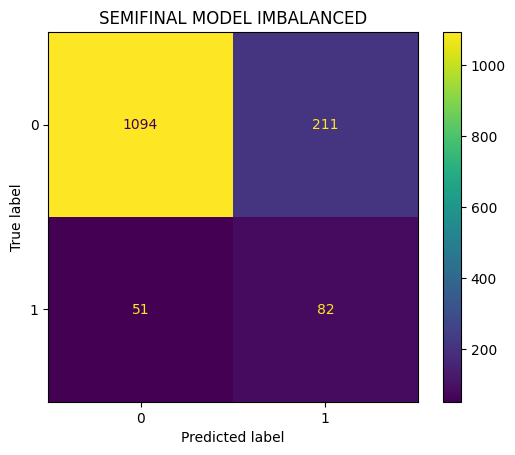

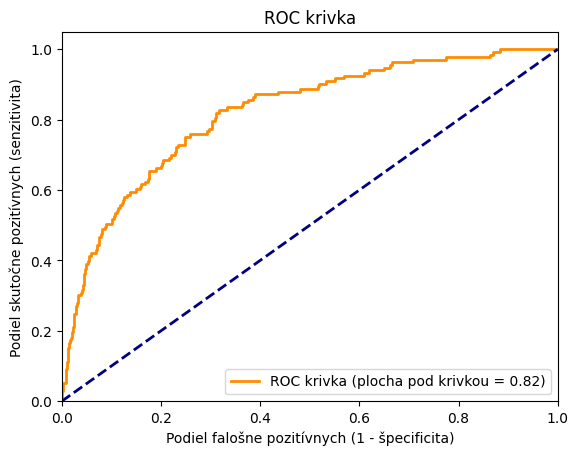

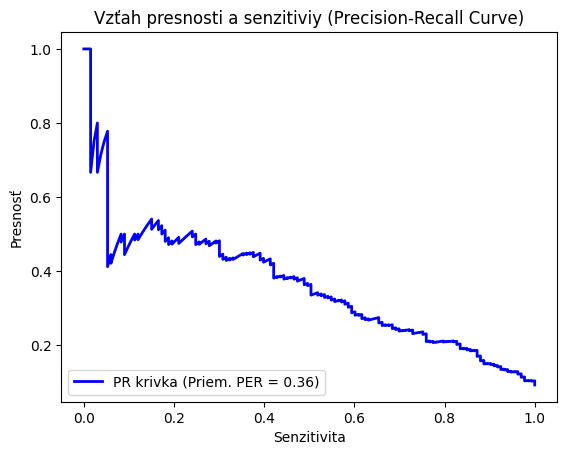

Threshold for 70% recall: 0.027617059648036957
Actual recall: 1.00
real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7531293463143255
FINAL MODEL IMBALANCED Precision: 0.23317307692307693
FINAL MODEL IMBALANCED Recall: 0.7293233082706767
FINAL MODEL IMBALANCED Specificity: 0.7555555555555555
FINAL MODEL IMBALANCED F1 Score: 0.3533697632058288


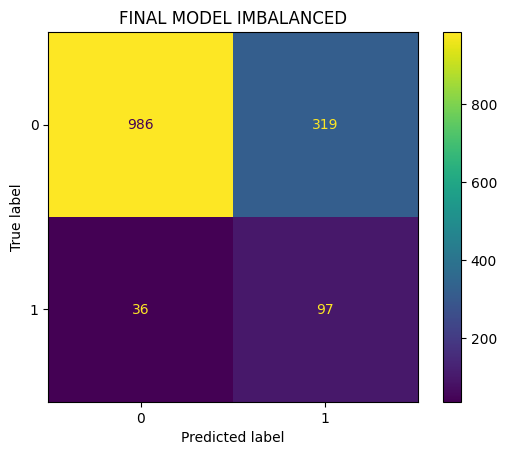

In [39]:

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    random_state = 37,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree=  0.7,
    learning_rate= 0.05,
    max_depth= 5,
    min_child_weight= 3,
    n_estimators= 80,
    subsample= 0.7
)

xgb_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, xgb_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = xgb_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()




# Find the threshold that achieves the target recall (70%)
target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

# Predict using the new threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the recall score with the new threshold
actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")




eval(y_valid_valid_imbalanced, predict_w_threshold(xgb_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

In [15]:
import xgboost as xgb

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.8234285714285714
FINAL MODEL TRAIN BALANCED Precision: 0.8138041733547352
FINAL MODEL TRAIN BALANCED Recall: 0.7242857142857143
FINAL MODEL TRAIN BALANCED Specificity: 0.8895238095238095
FINAL MODEL TRAIN BALANCED F1 Score: 0.7664399092970523


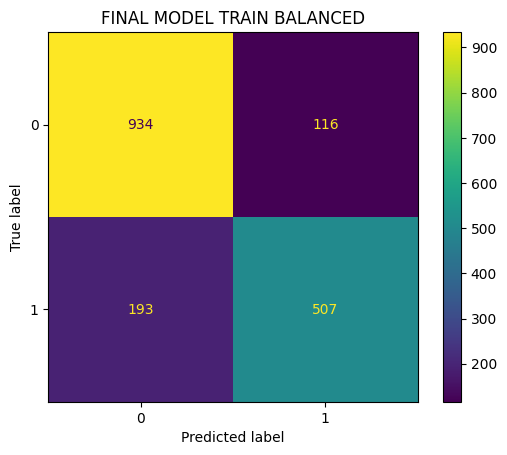

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7441860465116279
FINAL MODEL BALANCED Precision: 0.7012987012987013
FINAL MODEL BALANCED Recall: 0.627906976744186
FINAL MODEL BALANCED Specificity: 0.8217054263565892
FINAL MODEL BALANCED F1 Score: 0.6625766871165645


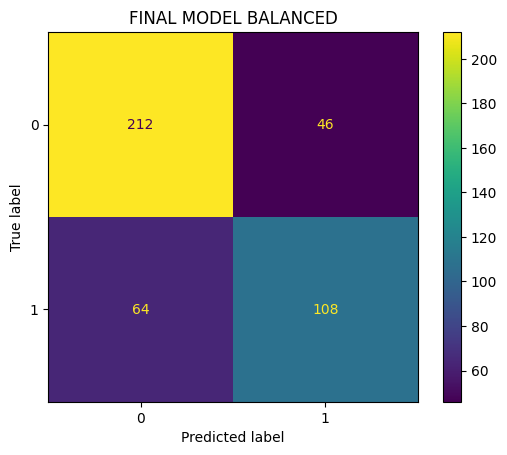

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8102392877017252
FINAL MODEL IMBALANCED Precision: 0.2805194805194805
FINAL MODEL IMBALANCED Recall: 0.627906976744186
FINAL MODEL IMBALANCED Specificity: 0.8295384615384616
FINAL MODEL IMBALANCED F1 Score: 0.3877917414721724


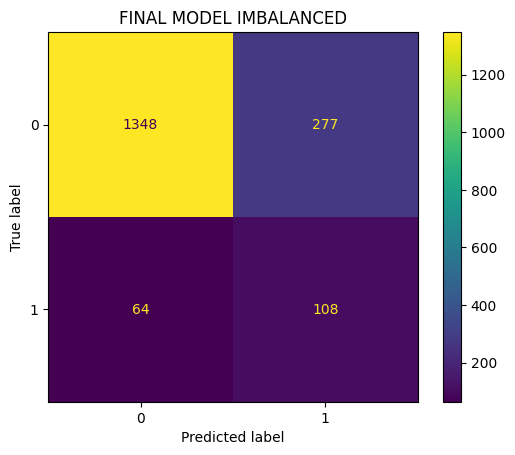

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7093023255813954
FINAL MODEL BALANCED Precision: 0.6230366492146597
FINAL MODEL BALANCED Recall: 0.6918604651162791
FINAL MODEL BALANCED Specificity: 0.7209302325581395
FINAL MODEL BALANCED F1 Score: 0.6556473829201103


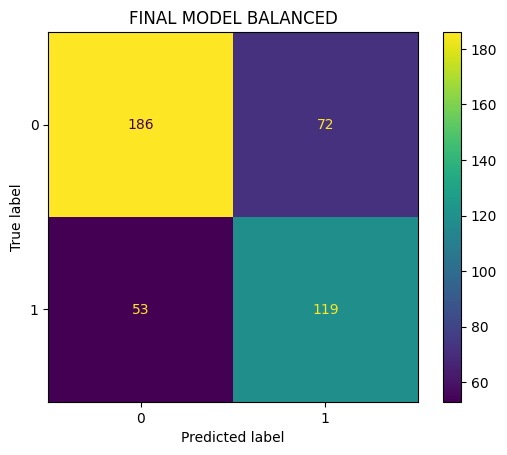

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7356705620478575
FINAL MODEL IMBALANCED Precision: 0.2199630314232902
FINAL MODEL IMBALANCED Recall: 0.6918604651162791
FINAL MODEL IMBALANCED Specificity: 0.7403076923076923
FINAL MODEL IMBALANCED F1 Score: 0.3338008415147265


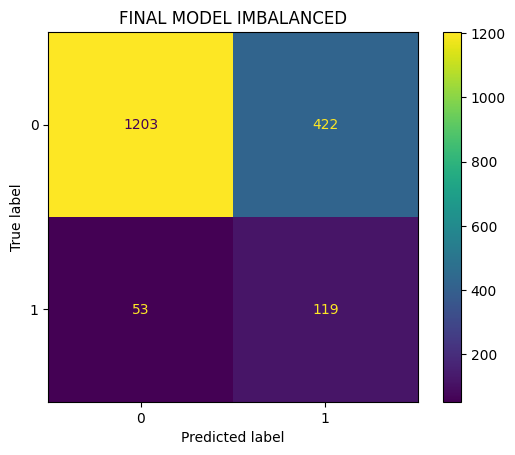

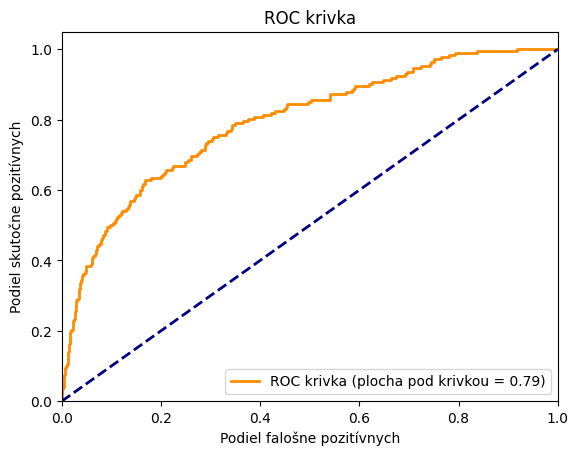

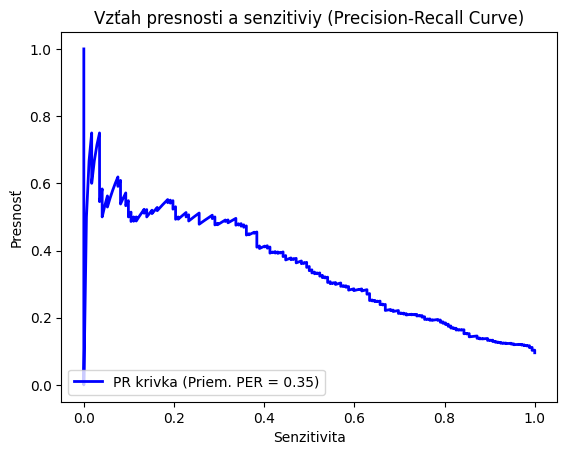

In [40]:
rf_final = xgb.XGBClassifier(
    random_state = 37,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree=  0.7,
    learning_rate= 0.05,
    max_depth= 5,
    min_child_weight= 3,
    n_estimators= 80,
    subsample= 0.7
)


rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_test_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

